# Dataset loading

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim # to optimize nural network
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader, random_split
from PIL import Image
import cv2
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'facial-emotion-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/facial-emotion-recognition-dataset


In [ ]:
path = os.path.join(path, "processed_data")
print(path)

/kaggle/input/facial-emotion-recognition-dataset/processed_data


In [ ]:
device= torch.device('cuda')
print(device)

cuda


# Statistics


📊Classes Number 7
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

📈 Distribution of images in each class
----------------------------------------
happy          :  11398 image
neutral        :   8166 image
sad            :   6535 image
angry          :   5920 image
disgust        :   5920 image
fear           :   5920 image
surprise       :   5920 image
----------------------------------------
Total          :  49779 image



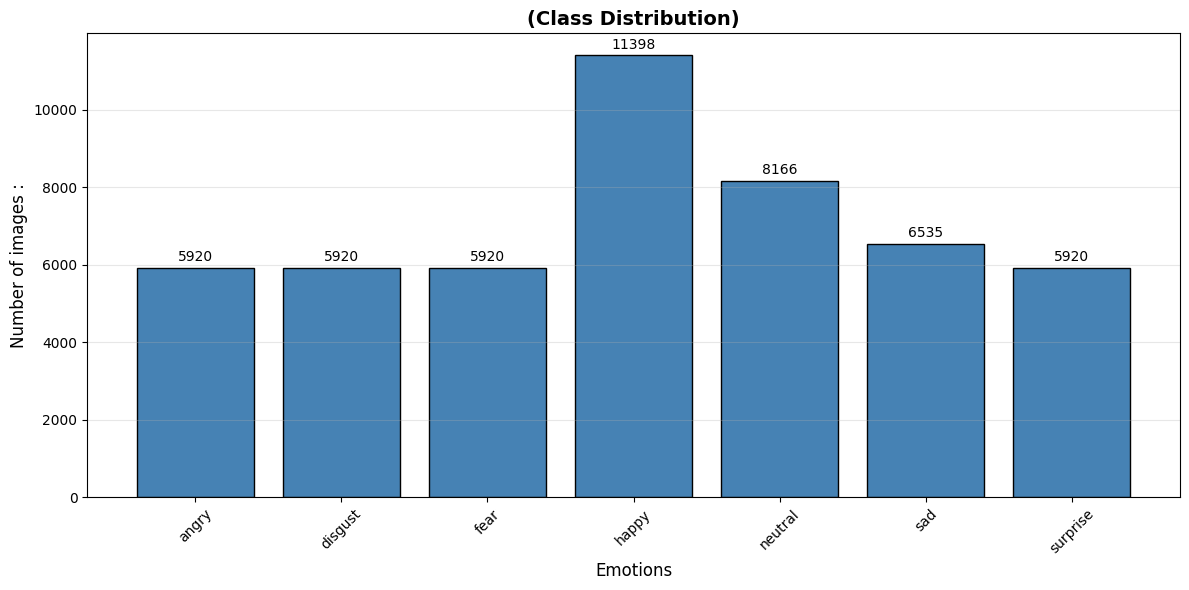


 🔍Check the dimensions of the images...
  angry_03606.jpg: (96, 96, 3)
  angry_03629.jpg: (96, 96, 3)
  angry_02532.jpg: (96, 96, 3)
  angry_01524.jpg: (96, 96, 3)
  angry_02410.jpg: (96, 96, 3)


In [ ]:
emotions = sorted(os.listdir(path))
print(f"\n📊Classes Number {len(emotions)}")
print(f"Classes: {emotions}\n")

# calc no images in each category
emotion_counts = {}
for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    if os.path.isdir(emotion_path):
        count = len(os.listdir(emotion_path))
        emotion_counts[emotion] = count

# عرض الإحصائيات
print("📈 Distribution of images in each class")
print("-" * 40)
for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{emotion:15s}: {count:6d} image")

total_images = sum(emotion_counts.values())
print("-" * 40)
print(f"{'Total':15s}: {total_images:6d} image\n")

# رسم بياني للتوزيع
plt.figure(figsize=(12, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='steelblue', edgecolor='black')
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Number of images :', fontsize=12)
plt.title('(Class Distribution)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, (emotion, count) in enumerate(emotion_counts.items()):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# فحص أبعاد عينة من الصور
print("\n 🔍Check the dimensions of the images...")
sample_emotion = emotions[0]
sample_images_path = os.path.join(path, sample_emotion)
sample_images = os.listdir(sample_images_path)[:5]

for img_name in sample_images:
    img_path = os.path.join(sample_images_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        print(f"  {img_name}: {img.shape}")

Split data into training , test , valdiation

In [ ]:
from sklearn.model_selection import train_test_split

output_dir = 'emotion_split_data'
splits = ['train', 'val', 'test']

# حذف المجلد لو موجود
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# إنشاء المجلدات
for split in splits:
    for emotion in emotions:
        os.makedirs(os.path.join(output_dir, split, emotion), exist_ok=True)

print("\n📂 Starting data spliting...")
print("Percentages : Train=70%, Val=15%, Test=15%")
print("="*70)

split_stats = {split: {} for split in splits}

for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    images = [f for f in os.listdir(emotion_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # التقسيم
    train_data, temp_imgs = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_imgs, test_size=0.5, random_state=42, shuffle=True)

    # نسخ الصور
    for img_name in train_data:
        shutil.copy2(
            os.path.join(emotion_path, img_name),
            os.path.join(output_dir, 'train', emotion, img_name)
        )

    for img_name in val_data:
        shutil.copy2(
            os.path.join(emotion_path, img_name),
            os.path.join(output_dir, 'val', emotion, img_name)
        )

    for img_name in test_data:
        shutil.copy2(
            os.path.join(emotion_path, img_name),
            os.path.join(output_dir, 'test', emotion, img_name)
        )

    split_stats['train'][emotion] = len(train_data)
    split_stats['val'][emotion] = len(val_data)
    split_stats['test'][emotion] = len(test_data)

    print(f"{emotion:12s} | Train: {len(train_data):5d} | Val: {len(val_data):4d} | Test: {len(test_data):4d}")

print("="*70)

# الإجماليات
total_train = sum(split_stats['train'].values())
total_val = sum(split_stats['val'].values())
total_test = sum(split_stats['test'].values())
total_all = total_train + total_val + total_test




print(f"\n📊 Summary:")
print(f"Train:      {total_train:5d} image ({total_train/total_all*100:.1f}%)")
print(f"Validation: {total_val:5d} image ({total_val/total_all*100:.1f}%)")
print(f"Test:       {total_test:5d} image ({total_test/total_all*100:.1f}%)")


📂 Starting data spliting...
Percentages : Train=70%, Val=15%, Test=15%
angry        | Train:  4144 | Val:  888 | Test:  888
disgust      | Train:  4144 | Val:  888 | Test:  888
fear         | Train:  4144 | Val:  888 | Test:  888
happy        | Train:  7978 | Val: 1710 | Test: 1710
neutral      | Train:  5716 | Val: 1225 | Test: 1225
sad          | Train:  4574 | Val:  980 | Test:  981
surprise     | Train:  4144 | Val:  888 | Test:  888

📊 Summary:
Train:      34844 image (70.0%)
Validation:  7467 image (15.0%)
Test:        7468 image (15.0%)


# CNN

## preprocessing

Data augmentation

In [ ]:
print("\n" + "="*70)
print(" Building Transforms for CNN model...") #for CNN
print("="*70)

IMG_SIZE = 96
BATCH_SIZE = 32

# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Validation & Test transforms (without augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3), # transform grey images into 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✅ Transforms Done !")



 Building Transforms for CNN model...
✅ Transforms Done !


Dataset Using ImageFolder and Dataloader


In [ ]:
print("\n📦 Building Datasets...")

# using ImageFolder
train_dataset = ImageFolder(
    root=os.path.join(output_dir, 'train'),
    transform=train_transforms
)

val_dataset = ImageFolder(
    root=os.path.join(output_dir, 'val'),
    transform=val_test_transforms
)

test_dataset = ImageFolder(
    root=os.path.join(output_dir, 'test'),
    transform=val_test_transforms
)

print(f"✅ Train dataset: {len(train_dataset)} image")
print(f"✅ Val dataset:   {len(val_dataset)} image")
print(f"✅ Test dataset:  {len(test_dataset)} image")

# عرض class indices
print(f"\nClass to Index mapping:")
for emotion, idx in train_dataset.class_to_idx.items():
    print(f"  {emotion:12s} -> {idx}")


📦 Building Datasets...
✅ Train dataset: 34844 image
✅ Val dataset:   7467 image
✅ Test dataset:  7468 image

Class to Index mapping:
  angry        -> 0
  disgust      -> 1
  fear         -> 2
  happy        -> 3
  neutral      -> 4
  sad          -> 5
  surprise     -> 6


In [ ]:
print("\n🔄 Building DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,

)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,

)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,

)
num_classes = 7

print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Val batches:   {len(val_loader)}")
print(f"✅ Test batches:  {len(test_loader)}")


🔄 Building DataLoaders...
✅ Train batches: 1089
✅ Val batches:   234
✅ Test batches:  234


Calc Class Weights

In [ ]:
print("\n" + "="*70)
print("⚖️ Calc Class Weights...")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# حساب class weights
class_counts = [split_stats['train'][emotion] for emotion in emotions]
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(emotions)),
    y=np.repeat(np.arange(len(emotions)), class_counts)
)

class_weights = torch.FloatTensor(class_weights_array).to(device)

print("\nClass Weights:")
for idx, emotion in enumerate(emotions):
    print(f"{emotion:12s}: {class_weights[idx]:.3f} ( Number of images: {class_counts[idx]})")



⚖️ Calc Class Weights...

Class Weights:
angry       : 1.201 ( Number of images: 4144)
disgust     : 1.201 ( Number of images: 4144)
fear        : 1.201 ( Number of images: 4144)
happy       : 0.624 ( Number of images: 7978)
neutral     : 0.871 ( Number of images: 5716)
sad         : 1.088 ( Number of images: 4574)
surprise    : 1.201 ( Number of images: 4144)



🖼️ Show sample images...


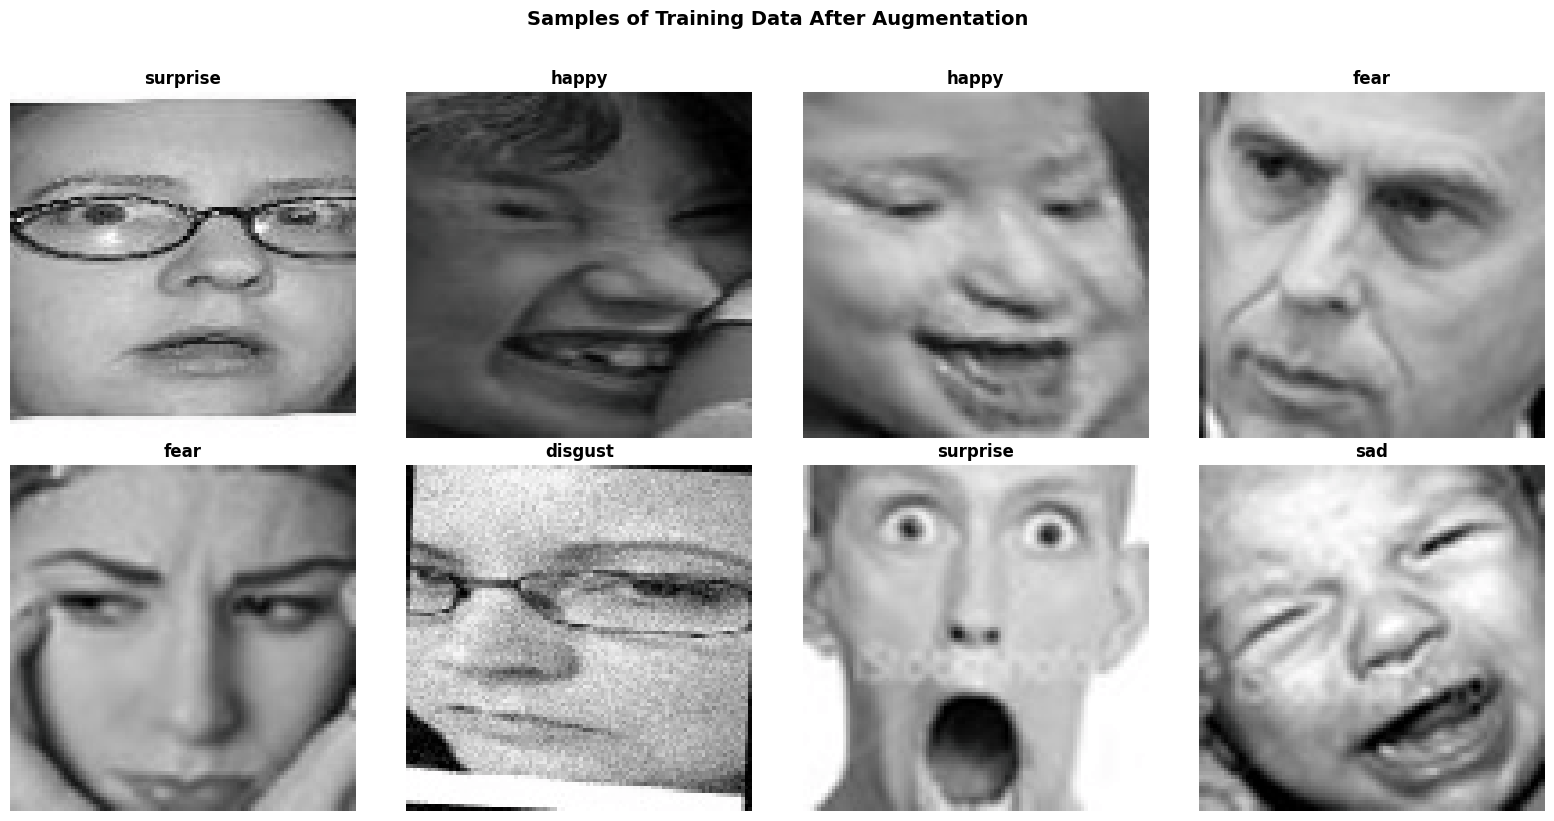

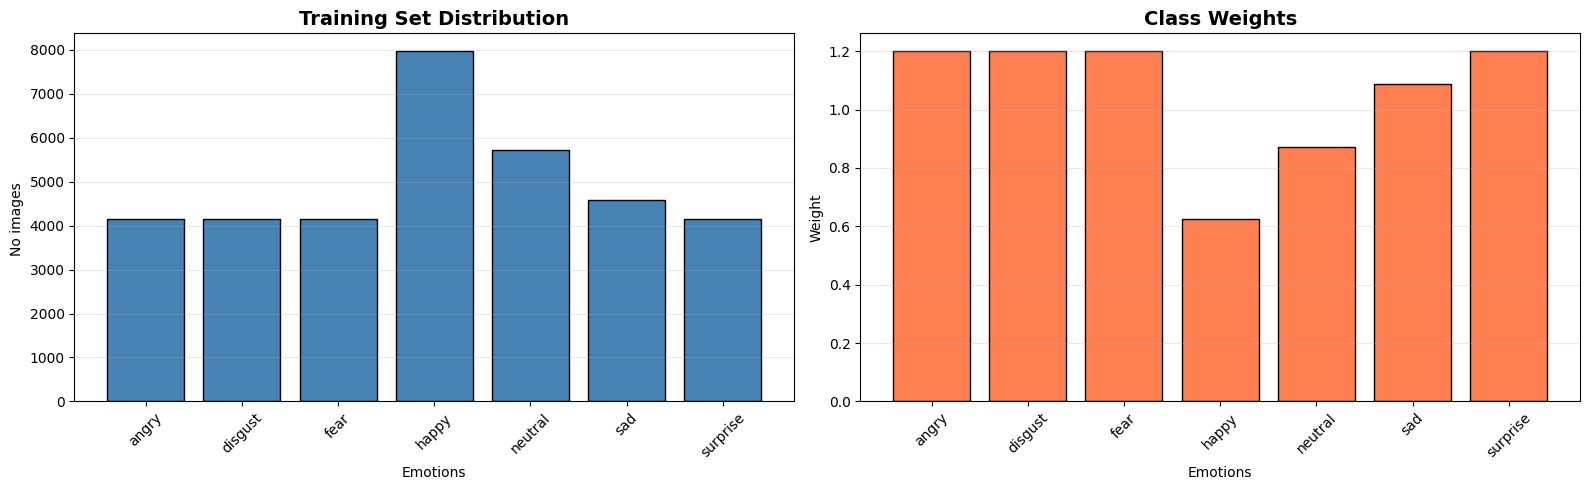

In [ ]:
print("\n" + "="*70)
print("🖼️ Show sample images...")
print("="*70)

# دالة لعكس normalization للعرض
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# أخذ batch من training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# عرض 8 صور
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

for i in range(8):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(f"{idx_to_class[labels[i].item()]}",
                     fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Samples of Training Data After Augmentation',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# رسم توزيع الفئات
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Training distribution
ax1.bar(emotions, [split_stats['train'][e] for e in emotions],
        color='steelblue', edgecolor='black')
ax1.set_title('Training Set Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotions')
ax1.set_ylabel('No images ')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Class weights
ax2.bar(emotions, class_weights.cpu().numpy(),
        color='coral', edgecolor='black')
ax2.set_title('Class Weights', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emotions')
ax2.set_ylabel('Weight')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Model Design and Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()    # أو: super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.3)

        # Block 4
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7   = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8   = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout2d(0.3)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)   # flatten

        # Fully Connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout5(x)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout6(x)

        x = self.fc3(x)
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2) ## البابا


epochs = 100
early_stop_patience = 5  # عدد epochs اللي هنستنىها قبل التوقف
no_improve_epochs = 0    # عداد للـ epochs بدون تحسن
best_acc = 0
best_model_state = None

# -----------------------
# TRAINING LOOP
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # VALIDATION
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = model.state_dict()

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{epochs} "
          f"- Train Loss: {train_loss/len(train_loader):.4f} "
          f"- Val Loss: {val_loss/len(val_loader):.4f} "
          f"- Val Acc: {val_acc:.2f}%")
    # Early stopping
if val_acc > best_acc:
    best_acc = val_acc
    best_model_state = model.state_dict()
    no_improve_epochs = 0   # مهم جدًا
else:
    no_improve_epochs += 1  # لو مفيش تحسن نزود العداد

# Load best model
model.load_state_dict(best_model_state)
print(f"\nBest Validation Accuracy: {best_acc:.2f}%")

Epoch 1/100 - Train Loss: 1.7896 - Val Loss: 1.6909 - Val Acc: 30.03%
Epoch 2/100 - Train Loss: 1.7171 - Val Loss: 1.6489 - Val Acc: 32.29%
Epoch 3/100 - Train Loss: 1.6538 - Val Loss: 1.4918 - Val Acc: 43.40%
Epoch 4/100 - Train Loss: 1.5000 - Val Loss: 1.3632 - Val Acc: 47.38%
Epoch 5/100 - Train Loss: 1.4119 - Val Loss: 1.2538 - Val Acc: 51.49%
Epoch 6/100 - Train Loss: 1.3517 - Val Loss: 1.1870 - Val Acc: 53.53%
Epoch 7/100 - Train Loss: 1.3040 - Val Loss: 1.1492 - Val Acc: 55.95%
Epoch 8/100 - Train Loss: 1.2649 - Val Loss: 1.1272 - Val Acc: 55.99%
Epoch 9/100 - Train Loss: 1.2307 - Val Loss: 1.0821 - Val Acc: 58.42%
Epoch 10/100 - Train Loss: 1.2038 - Val Loss: 1.0434 - Val Acc: 59.50%
Epoch 11/100 - Train Loss: 1.1734 - Val Loss: 1.0173 - Val Acc: 61.59%
Epoch 12/100 - Train Loss: 1.1505 - Val Loss: 1.0033 - Val Acc: 61.32%
Epoch 13/100 - Train Loss: 1.1220 - Val Loss: 0.9620 - Val Acc: 63.77%
Epoch 14/100 - Train Loss: 1.0986 - Val Loss: 0.9533 - Val Acc: 64.07%
Epoch 15/100 - 

## Eavluation

In [ ]:
# TEST ACCURACY
# -----------------------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"\nFINAL TEST ACCURACY: {test_acc:.2f}%")


FINAL TEST ACCURACY: 74.33%


Test Accuracy: 74.33%


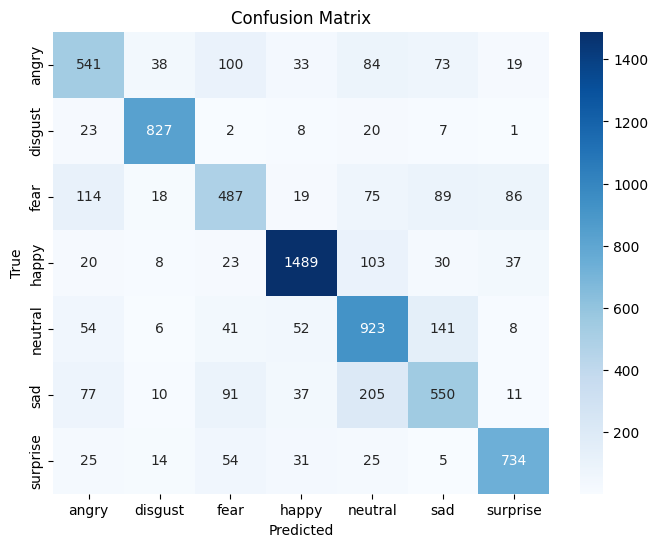

Classification Report:

              precision    recall  f1-score   support

       angry       0.63      0.61      0.62       888
     disgust       0.90      0.93      0.91       888
        fear       0.61      0.55      0.58       888
       happy       0.89      0.87      0.88      1710
     neutral       0.64      0.75      0.69      1225
         sad       0.61      0.56      0.59       981
    surprise       0.82      0.83      0.82       888

    accuracy                           0.74      7468
   macro avg       0.73      0.73      0.73      7468
weighted avg       0.74      0.74      0.74      7468



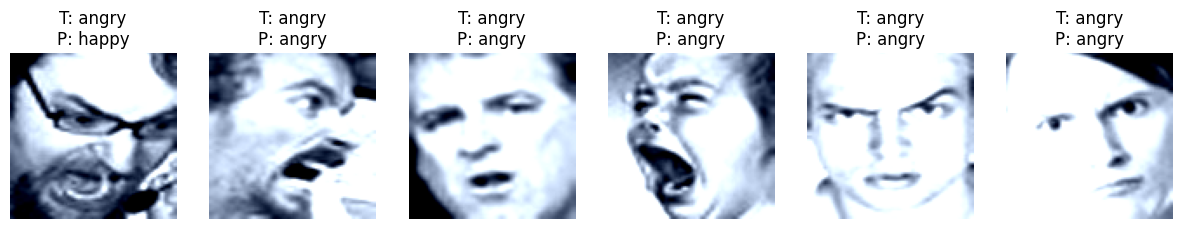

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------
# EVALUATION ON TEST SET
# ----------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1️⃣ Accuracy
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 2️⃣ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3️⃣ Classification Report
report = classification_report(all_labels, all_preds, target_names=emotions)
print("Classification Report:\n")
print(report)

# 4️⃣ Optional: Visualize some predictions
def visualize_predictions(loader, model, num_images=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15,5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().permute(1,2,0).numpy()
                img = (img * 0.5) + 0.5  # unnormalize if normalized with mean=0.5,std=0.5
                plt.subplot(1, num_images, images_shown+1)
                plt.imshow(img)
                plt.title(f"T: {emotions[labels[i]]}\nP: {emotions[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

# Call visualization function
visualize_predictions(test_loader, model)


# swin

In [ ]:
from tqdm import tqdm
import timm
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns



## preprocessing

Split

In [ ]:
source = path
output = "/content/Split_Dataset"

# Ensure output directory is clean if it exists from previous runs
if os.path.exists(output):
    shutil.rmtree(output)

os.makedirs(output, exist_ok=True)

splits = ["train", "test"]
for split in splits:
    os.makedirs(os.path.join(output, split), exist_ok=True)

test_ratio = 0.2

for class_name in os.listdir(source):
    class_path = os.path.join(source, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    test_count = int(len(images) * test_ratio)
    test_imgs = images[:test_count]
    train_imgs = images[test_count:]

    os.makedirs(os.path.join(output, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(output, "test", class_name), exist_ok=True)

    for img in train_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(output, "train", class_name, img)
        if os.path.exists(dst): # Check if symlink already exists
            os.remove(dst)       # Remove it if it does
        os.symlink(src, dst)

    for img in test_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(output, "test", class_name, img)
        if os.path.exists(dst): # Check if symlink already exists
            os.remove(dst)       # Remove it if it does
        os.symlink(src, dst)

print("DONE — split created!")

Data augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

ImageFolder and Dataloader

In [ ]:
from torchvision.datasets import ImageFolder

train_dir = "/content/Split_Dataset/train"
test_dir = "/content/Split_Dataset/test"

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train samples: 39824
Test samples: 9955


class_weight

In [ ]:
from sklearn.utils import class_weight
y_train = np.array(train_dataset.targets)
classes_present = np.unique(y_train)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_present,
    y=y_train
)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)


## Model bulding and training

In [ ]:
!pip install timm

In [ ]:
import timm
import torch.nn as nn

num_classes = len(train_dataset.classes)

model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
# FREEZE FIRST (head only training)

for param in model.parameters():
    param.requires_grad = False
# Allow head to train
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
import torch.optim as optim
import torch

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


model = model.to(device)


In [ ]:
# Training Parameters
# -------------------
best_acc = 0
EPOCHS = 60
patience = 10           # Early stopping patience
trigger_times = 0
best_val_loss = float('inf')
checkpoint_interval = 5
# Gradient clipping value
grad_clip = 2.0

In [ ]:

# Training Loop
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for imgs, labels in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        if outputs.dim() > 2:
            outputs = outputs.mean(dim=[-1, -2])  # global pooling for Swin

        loss = criterion(outputs, labels)
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        loopv = tqdm(test_loader, desc="Validating", leave=False)
        for imgs, labels in loopv:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            if outputs.dim() > 2:
                outputs = outputs.mean(dim=[-1, -2])

            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loopv.set_postfix(val_loss=(val_loss / (len(loopv))))

    val_loss_avg = val_loss / len(test_loader)
    val_acc = correct / total

    # scheduler step
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:.4f}")

    # Unfreeze full model after 5 epochs
    if epoch == 5:
        print(" Unfreezing full model parameters")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': train_dataset.classes
        }, "best_swin_dataset.pth")
        print(" New best model saved with val_acc:", best_acc)

    # Checkpoint
    if epoch % checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': train_dataset.classes
        }, f"checkpoint_epoch_{epoch}.pth")
        print(f"Checkpoint saved at epoch {epoch}")

    # Early Stopping
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"EarlyStopping trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f" Early stopping at epoch {epoch}")
            break

print("\nFinished Training. Best Val Acc:", best_acc)


Epoch 1/60


Train Loss: 1.4467 | Val Loss: 1.1667 | Val Acc: 0.5738
 New best model saved with val_acc: 0.5737820190858864

Epoch 2/60


Train Loss: 1.3563 | Val Loss: 1.1226 | Val Acc: 0.5980
 New best model saved with val_acc: 0.5979909593169261

Epoch 3/60


Train Loss: 1.3329 | Val Loss: 1.0995 | Val Acc: 0.5985
 New best model saved with val_acc: 0.5984932194876946

Epoch 4/60


Train Loss: 1.3173 | Val Loss: 1.0984 | Val Acc: 0.6003
 New best model saved with val_acc: 0.600301356102461

Epoch 5/60


Train Loss: 1.3113 | Val Loss: 1.0939 | Val Acc: 0.6015
 Unfreezing full model parameters
 New best model saved with val_acc: 0.6015067805123053
Checkpoint saved at epoch 5

Epoch 6/60


Train Loss: 1.2334 | Val Loss: 0.8565 | Val Acc: 0.6901
 New best model saved with val_acc: 0.6901054746358614

Epoch 7/60


Train Loss: 1.0951 | Val Loss: 0.7918 | Val Acc: 0.7257
 New best model saved with val_acc: 0.7256654947262682

Epoch 8/60


Train Loss: 1.0184 | Val Loss: 0.7012 | Val Acc: 0.7595
 New best model saved with val_acc: 0.7595178302360622

Epoch 9/60


Train Loss: 0.9567 | Val Loss: 0.7099 | Val Acc: 0.7600
 New best model saved with val_acc: 0.7600200904068307
EarlyStopping trigger times: 1/10

Epoch 10/60


Train Loss: 0.9067 | Val Loss: 0.6945 | Val Acc: 0.7628
 New best model saved with val_acc: 0.7628327473631341
Checkpoint saved at epoch 10

Epoch 11/60


Train Loss: 0.8600 | Val Loss: 0.7094 | Val Acc: 0.7625
EarlyStopping trigger times: 1/10

Epoch 12/60


Train Loss: 0.8200 | Val Loss: 0.6616 | Val Acc: 0.7833
 New best model saved with val_acc: 0.7833249623304872

Epoch 13/60


Train Loss: 0.7761 | Val Loss: 0.6504 | Val Acc: 0.7909
 New best model saved with val_acc: 0.7908588648920141

Epoch 14/60


Train Loss: 0.7439 | Val Loss: 0.6802 | Val Acc: 0.7829
EarlyStopping trigger times: 1/10

Epoch 15/60


Train Loss: 0.7071 | Val Loss: 0.6572 | Val Acc: 0.7938
 New best model saved with val_acc: 0.7937719738824711
Checkpoint saved at epoch 15
EarlyStopping trigger times: 2/10

Epoch 16/60


Train Loss: 0.6788 | Val Loss: 0.6806 | Val Acc: 0.7906
EarlyStopping trigger times: 3/10

Epoch 17/60


Train Loss: 0.6497 | Val Loss: 0.6674 | Val Acc: 0.7974
 New best model saved with val_acc: 0.7973882471120041
EarlyStopping trigger times: 4/10

Epoch 18/60


Train Loss: 0.6268 | Val Loss: 0.6470 | Val Acc: 0.8035
 New best model saved with val_acc: 0.8035158211953792

Epoch 19/60


Train Loss: 0.6047 | Val Loss: 0.6653 | Val Acc: 0.8035
EarlyStopping trigger times: 1/10

Epoch 20/60


Train Loss: 0.5879 | Val Loss: 0.6704 | Val Acc: 0.8071
 New best model saved with val_acc: 0.8071320944249121
Checkpoint saved at epoch 20
EarlyStopping trigger times: 2/10

Epoch 21/60


Train Loss: 0.5688 | Val Loss: 0.6822 | Val Acc: 0.8100
 New best model saved with val_acc: 0.8100452034153691
EarlyStopping trigger times: 3/10

Epoch 22/60


Train Loss: 0.5535 | Val Loss: 0.6872 | Val Acc: 0.8045
EarlyStopping trigger times: 4/10

Epoch 23/60


Train Loss: 0.5426 | Val Loss: 0.6850 | Val Acc: 0.8137
 New best model saved with val_acc: 0.8136614766449021
EarlyStopping trigger times: 5/10

Epoch 24/60


Train Loss: 0.5297 | Val Loss: 0.6925 | Val Acc: 0.8099
EarlyStopping trigger times: 6/10

Epoch 25/60


Train Loss: 0.5208 | Val Loss: 0.6942 | Val Acc: 0.8116
Checkpoint saved at epoch 25
EarlyStopping trigger times: 7/10

Epoch 26/60


Train Loss: 0.5123 | Val Loss: 0.7139 | Val Acc: 0.8124
EarlyStopping trigger times: 8/10

Epoch 27/60


Train Loss: 0.5058 | Val Loss: 0.6912 | Val Acc: 0.8181
 New best model saved with val_acc: 0.8180813661476645
EarlyStopping trigger times: 9/10

Epoch 28/60


Train Loss: 0.5014 | Val Loss: 0.6893 | Val Acc: 0.8203
 New best model saved with val_acc: 0.8202913108990457
EarlyStopping trigger times: 10/10
 Early stopping at epoch 28

Finished Training. Best Val Acc: 0.8202913108990457


In [ ]:
!pip install torchinfo

from torchinfo import summary
import torch
import timm


summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [1, 7]                    --
├─PatchEmbed: 1-1                                  [1, 56, 56, 96]           --
│    └─Conv2d: 2-1                                 [1, 96, 56, 56]           4,704
│    └─LayerNorm: 2-2                              [1, 56, 56, 96]           192
├─Sequential: 1-2                                  [1, 7, 7, 768]            --
│    └─SwinTransformerStage: 2-3                   [1, 56, 56, 96]           --
│    │    └─Identity: 3-1                          [1, 56, 56, 96]           --
│    │    └─Sequential: 3-2                        [1, 56, 56, 96]           224,694
│    └─SwinTransformerStage: 2-4                   [1, 28, 28, 192]          --
│    │    └─PatchMerging: 3-3                      [1, 28, 28, 192]          74,496
│    │    └─Sequential: 3-4                        [1, 28, 28, 192]          891,756
│    └─SwinTransf

In [ ]:
from google.colab import files
files.download("best_swin_dataset.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import seaborn as sns


In [ ]:
def full_evaluation(model, test_loader, classes, device):
    """
    Complete evaluation for classification models.
    Includes accuracy, report, confusion matrix, and per-class metrics.
    """

    all_preds = []
    all_labels = []

    class_names = classes  # already sorted from dataset

    model.eval()

    # ============================
    # Inference Loop
    # ============================
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # For Swin / ViT (feature map -> pooling)
            if outputs.dim() > 2:
                outputs = outputs.mean(dim=[-1, -2])

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ============================
    # Overall Accuracy
    # ============================
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Overall Accuracy: {acc:.4f}")

    # ============================
    # Classification Report
    # ============================
    print("\n📊 Classification Report:\n")
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
    print(report)

    # Save report
    report_dict = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )
    df_report = pd.DataFrame(report_dict).transpose()
    df_report.to_csv("evaluation_report.csv")
    print("📁 Saved: evaluation_report.csv")

    # ============================
    # Confusion Matrix
    # ============================
    cm = confusion_matrix(all_labels, all_preds)

    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i][j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i][j]))

    confusion_pairs = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)

    print("\n🔍 Top 5 Most Confused Pairs:")
    for pair in confusion_pairs[:5]:
        print(f"{pair[0]} → {pair[1]} : {pair[2]} times")

    # ============================
    # Per-Class Metrics
    # ============================
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_f1 = df_report.loc[class_names, "f1-score"].values

    print("\n📌 Per-Class Accuracy & F1:")
    for i, name in enumerate(class_names):
        print(f"{name}:   Acc={class_accuracy[i]:.4f},  F1={class_f1[i]:.4f}")

    # ============================
    # Return Everything
    # ============================
    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "report": df_report,
        "class_acc": class_accuracy,
        "class_f1": class_f1
    }


In [ ]:
results = full_evaluation(model, test_loader, classes, device)



✅ Overall Accuracy: 0.8203

📊 Classification Report:

              precision    recall  f1-score   support

       angry     0.8018    0.7348    0.7669      1184
     disgust     0.9669    0.9611    0.9640      1184
        fear     0.7700    0.6926    0.7292      1184
       happy     0.9067    0.9215    0.9140      2279
     neutral     0.7091    0.8059    0.7544      1633
         sad     0.6996    0.6611    0.6798      1307
    surprise     0.8665    0.8936    0.8798      1184

    accuracy                         0.8203      9955
   macro avg     0.8172    0.8101    0.8126      9955
weighted avg     0.8207    0.8203    0.8195      9955

📁 Saved: evaluation_report.csv

🔍 Top 5 Most Confused Pairs:
sad → neutral : 216 times
neutral → sad : 124 times
angry → sad : 111 times
happy → neutral : 107 times
fear → sad : 97 times

📌 Per-Class Accuracy & F1:
angry:   Acc=0.7348,  F1=0.7669
disgust:   Acc=0.9611,  F1=0.9640
fear:   Acc=0.6926,  F1=0.7292
happy:   Acc=0.9215,  F1=0.9140
neut

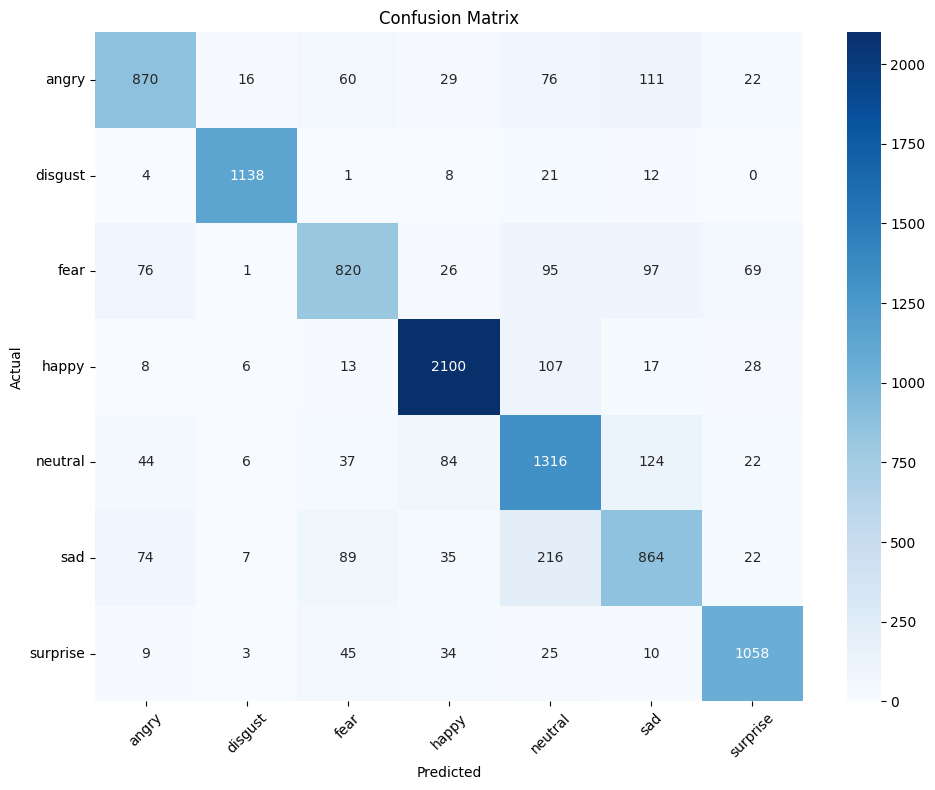

In [ ]:
cm = results["confusion_matrix"]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


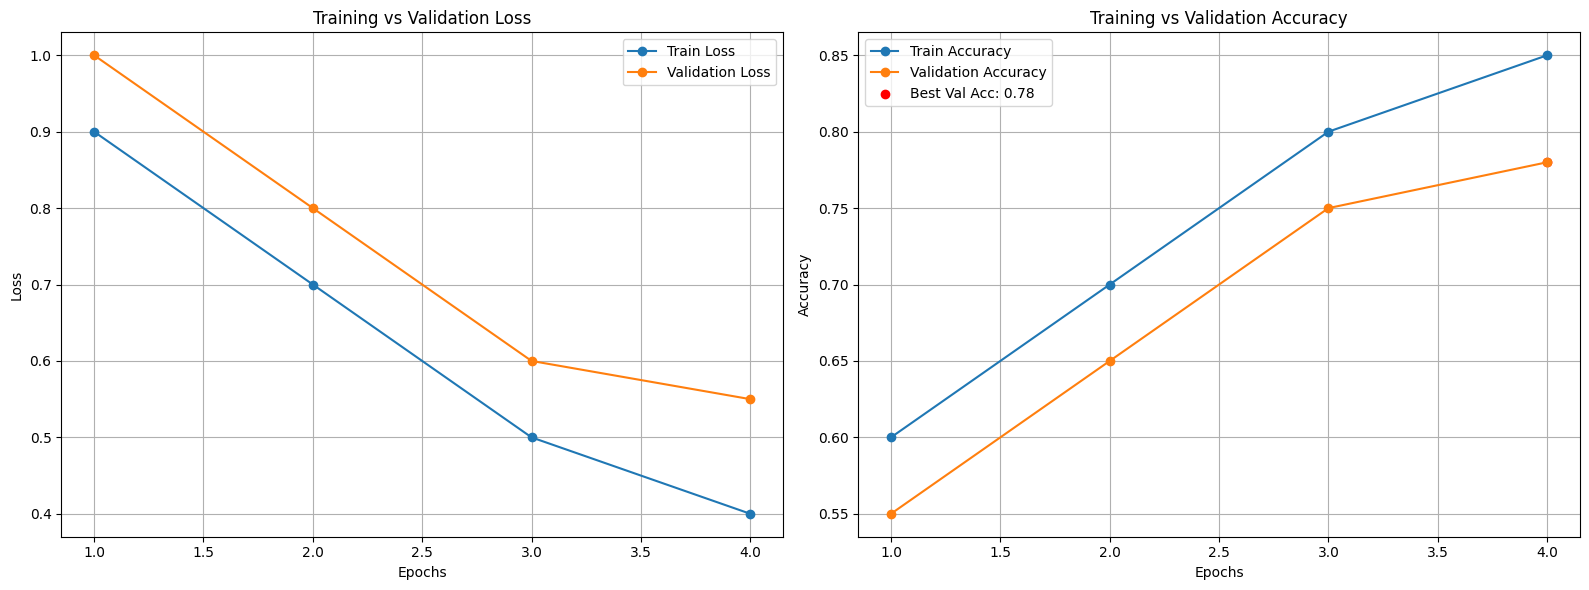

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plots training and validation loss and accuracy curves.

    Parameters:
    history: dict containing keys:
        - train_loss
        - val_loss
        - train_acc
        - val_acc
    """

    # Number of epochs
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(16, 6))

    # =======================
    #  Loss Plot
    # =======================
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')  # Training loss
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')  # Validation loss
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # =======================
    #  Accuracy Plot
    # =======================
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')  # Training accuracy
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='o')  # Validation accuracy

    # Highlight the best validation accuracy
    best_val = max(history["val_acc"])
    best_epoch = history["val_acc"].index(best_val) + 1
    plt.scatter(best_epoch, best_val, color='red', label=f'Best Val Acc: {best_val}')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

# Example usage
history = {
    "train_loss": [0.9, 0.7, 0.5, 0.4],
    "val_loss": [1.0, 0.8, 0.6, 0.55],
    "train_acc": [0.6, 0.7, 0.8, 0.85],
    "val_acc": [0.55, 0.65, 0.75, 0.78]
}

plot_training_curves(history)
